In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from shap import TreeExplainer, decision_plot, Explainer
from shap.plots import beeswarm
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('data/strat_weighted3.csv')
# Restrict to working age women
df = df[df['Gender'] == 'Female']
df = df[df['Age'] >= 15]

df.dropna(subset=['MPCE_qrt'], inplace=True)

# Table 10

In [2]:
df['Urban'] = (df['sector'] == 'Urban').astype(int)

# Rename MPCE quartiles to be more readable
df['MPCE_qrt'].replace({'50-75': 'Third MPCE Quartile', '0-25': 'Lowest MPCE Quartile', '25-50': 'Second MPCE Quartile', '75-100': 'Top MPCE Quartile'}, inplace=True)

# Create the common feature columns
sg_order = pd.CategoricalDtype(categories=['Others', 'ST', 'SC', 'OBC'], ordered=True)
df['Social group'] = df['Social_group_'].astype(sg_order)

religion_order = pd.CategoricalDtype(categories=['Hinduism', 'Islam', 'Christianity', 'Sikkhism', 'Jainism', 'Buddhism', 'Zoroastrianism', 'others'], ordered=True)
df['Religion'] = df['religion'].astype(religion_order)

df['MPCE'] = df['MPCE_qrt'].astype(pd.CategoricalDtype(categories=['Lowest MPCE Quartile', 'Second MPCE Quartile', 'Third MPCE Quartile', 'Top MPCE Quartile'], ordered=True))
df['Education'] = df['education'].astype(pd.CategoricalDtype(categories=['Illiterate', 'Upto Middle School', 'Secondary', 'Higher Secondary', 'Graduate and above'], ordered=True))

xComm = pd.concat(
    [ 
        df[['Urban', 'Age']],
        pd.get_dummies(df[['Social group', 'Religion', 'MPCE', 'Education']], drop_first=True, prefix='', prefix_sep='').astype(int),
        # pd.get_dummies(df['state_codes'], prefix="", prefix_sep="").astype(int)
    ],
    axis=1)

# List the spec columns
df['Piped Gas/LPG Present'] = (df['piped_gas'] == 'Piped Gas/LPG Present').astype(int)
df['Access to Electricity'] = (df['wired_source'] == 'electricity').astype(int)
df['Washing'] = df['washing_type'].replace(
    {'Manual': 'Washing: Manual', 'Mechanised': "Washing: Mechanised", "Outsourcing": "Washing: Outsourced"}
).astype(pd.CategoricalDtype(categories=['Washing: Manual', "Washing: Mechanised", "Washing: Outsourced"], ordered=True))
df['Sweeping'] = df['sweeeping_type'].replace(
    {'Manual': 'Sweeping: Manual', 'Mechanised': "Sweeping: Mechanised", "Outsourcing": "Sweeping: Outsourced"}
).astype(pd.CategoricalDtype(categories=['Sweeping: Manual', "Sweeping: Mechanised", "Sweeping: Outsourced"], ordered=True))

0.23805752753597942


Text(0.5, 0, 'Deviation from average time spent (mins)')

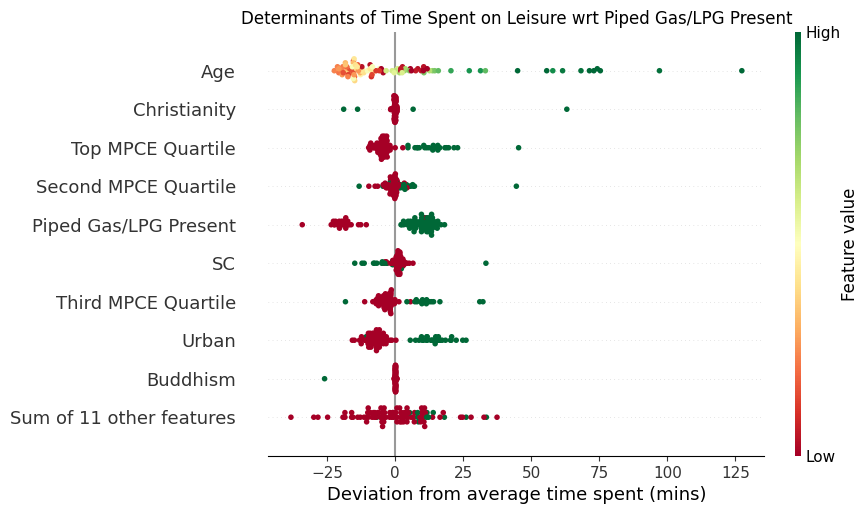

In [3]:
# (1). Access to Piped Gas/LPG --- Time spent on Leisure
target, spec = 'Time Spent on Leisure', 'Piped Gas/LPG Present'
X = pd.concat((df[spec], xComm, df['pweight'], df[target]), axis=1)
X.dropna(inplace=True)

weights = X.pop('pweight')
y = X.pop(target)

clf = RandomForestRegressor(n_jobs=-1, max_depth=20, max_features='sqrt').fit(X, y, sample_weight=weights)
print(clf.score(X, y, weights))
exp = TreeExplainer(clf, feature_perturbation='tree_path_dependent')
vals = exp(X.sample(100, weights=weights), check_additivity=False)
plt.figure()
beeswarm(vals, color='RdYlGn', show=False, order=vals.abs.max(0))
ax = plt.gca()
ax.set_title(f'Determinants of {target} wrt {spec}')
ax.set_xlabel('Deviation from average time spent (mins)')

0.2097402210605036


Text(0.5, 0, 'Deviation from average time spent (mins)')

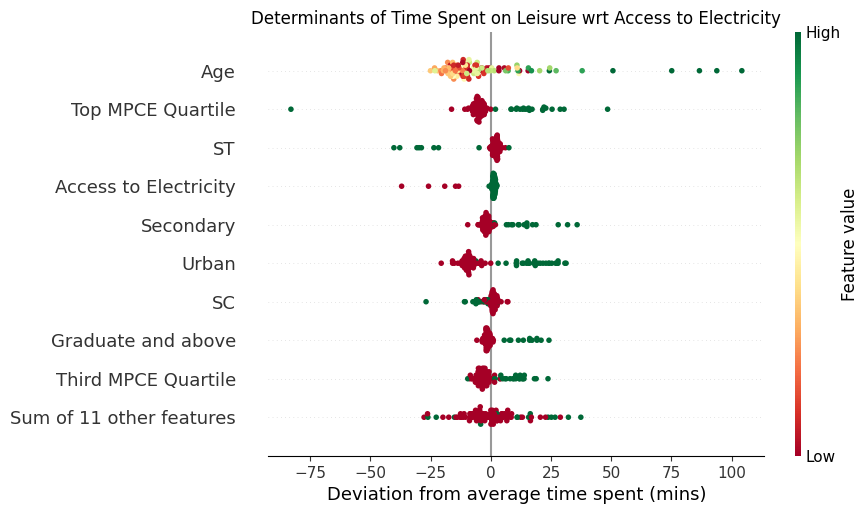

In [4]:
# (2). Electricity --- Time spent on Leisure
target, spec = 'Time Spent on Leisure', 'Access to Electricity'
X = pd.concat((df[spec], xComm, df['pweight'], df[target]), axis=1)
X.dropna(inplace=True)

weights = X.pop('pweight')
y = X.pop(target)

clf = RandomForestRegressor(n_jobs=-1, max_depth=20, max_features='sqrt').fit(X, y, sample_weight=weights)
print(clf.score(X, y, weights))
exp = TreeExplainer(clf, feature_perturbation='tree_path_dependent')
vals = exp(X.sample(100, weights=weights), check_additivity=False)
plt.figure()
beeswarm(vals, color='RdYlGn', show=False, order=vals.abs.max(0))
ax = plt.gca()
ax.set_title(f'Determinants of {target} wrt {spec}')
ax.set_xlabel('Deviation from average time spent (mins)')

0.22511472121464615


Text(0.5, 0, 'Deviation from average time spent (mins)')

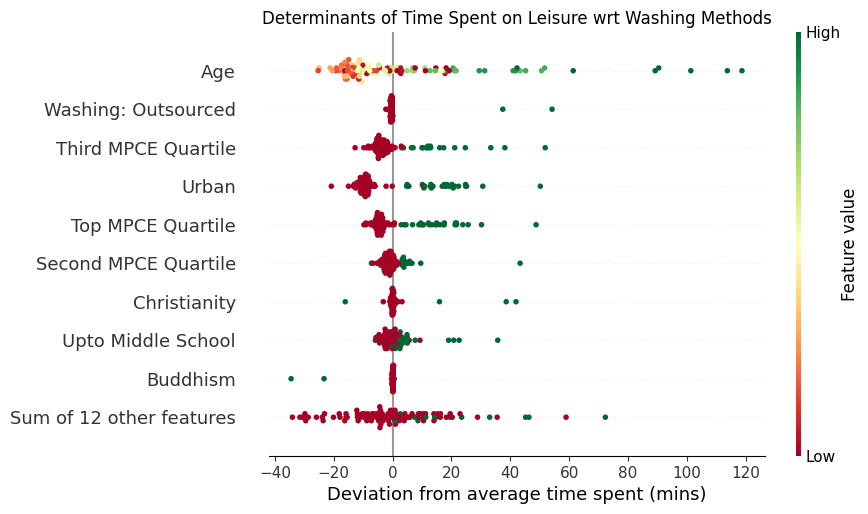

In [5]:
# (3). Washing methods --- Time spent on Leisure
target, spec = 'Time Spent on Leisure', 'Washing Methods'

X = pd.concat((
    pd.get_dummies(df['Washing'], drop_first=True, prefix="", prefix_sep="").astype(int), xComm, df['pweight'], df[target]), axis=1)
X.dropna(inplace=True)

weights = X.pop('pweight')
y = X.pop(target)

clf = RandomForestRegressor(n_jobs=-1, max_depth=20, max_features='sqrt').fit(X, y, sample_weight=weights)
print(clf.score(X, y, weights))
exp = TreeExplainer(clf, feature_perturbation='tree_path_dependent')
vals = exp(X.sample(100, weights=weights), check_additivity=False)
plt.figure()
beeswarm(vals, color='RdYlGn', show=False, order=vals.abs.max(0))
ax = plt.gca()
ax.set_title(f'Determinants of {target} wrt {spec}')
ax.set_xlabel('Deviation from average time spent (mins)')

0.21059292157575704


Text(0.5, 0, 'Deviation from average time spent (mins)')

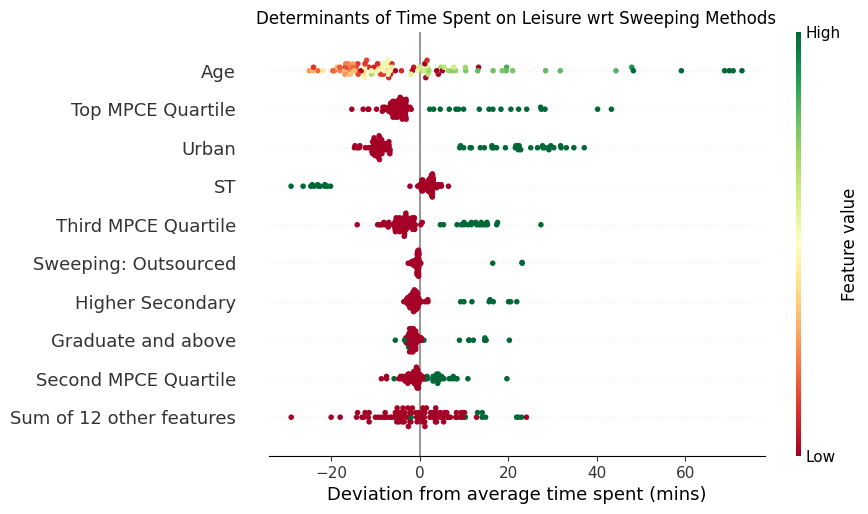

In [6]:
# (4). Sweeping Methods --- Time spent in on Leisure

target, spec = 'Time Spent on Leisure', 'Sweeping Methods'
X = pd.concat((
    pd.get_dummies(df['Sweeping'], drop_first=True, prefix="", prefix_sep="").astype(int), xComm, df['pweight'], df[target]), axis=1)
X.dropna(inplace=True)

weights = X.pop('pweight')
y = X.pop(target)

clf = RandomForestRegressor(n_jobs=-1, max_depth=20, max_features='sqrt').fit(X, y, sample_weight=weights)
print(clf.score(X, y, weights))
exp = TreeExplainer(clf, feature_perturbation='tree_path_dependent')
vals = exp(X.sample(100, weights=weights), check_additivity=False)
plt.figure()
beeswarm(vals, color='RdYlGn', show=False, order=vals.abs.max(0))
ax = plt.gca()
ax.set_title(f'Determinants of {target} wrt {spec}')
ax.set_xlabel('Deviation from average time spent (mins)')